In [1]:
#Pre-Processing

import os
import argparse
import networkx as nx
import math        
import numpy as np

def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def list_all_dir(data_dir):
    task_dirs = os.listdir(data_dir)

    list_dir = []
    for task_dir in task_dirs:
        env_dirs = os.listdir(data_dir+"/"+task_dir)
        for env_dir in env_dirs:
            list_dir.append(data_dir +"/"+ task_dir +"/"+ env_dir)
    return list_dir  

def process_it(G, directory):
    start = np.loadtxt(directory+"/start_nodes.txt")
    goal = np.loadtxt(directory+"/goal_nodes.txt")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt")
    # occ_grid = occ_grid.split(",")
    path_nodes = []
    i = 0
    all_data = []
    with open(directory + "/path_nodes.txt", 'r') as file:
        lines  = file.readlines()
        for line in lines:
            line = line.strip('\n')
#             print(line)
#             print("\n\n")
            
            s = state_to_numpy(G.node[str(int(start[i]))]['state'])
            g = state_to_numpy(G.node[str(int(goal[i]))]['state'])
            og = occ_grid[i]
            path_nodes = str(line).split(",")
            # print(path_nodes)
            for path_node in path_nodes:
                if(path_node=='-1'):
                    continue
                node_conf = state_to_numpy(G.node[path_node]['state'])
                curr_node = np.array([])
                # print("Data = ",node_conf, s, g, occ_grid)
#                     print("\n")
#                     print("node_conf = ", node_conf, " s = ", s, " g = ",g)

                curr_node = np.concatenate((node_conf, s, g, og))
#                     print("shape of curr_node = ", curr_node.shape)
                all_data.append(curr_node)
            i+=1
    return all_data

In [2]:
# Workspace problem with several narrow gaps

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time

# (restrict tensorflow memory growth)
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim*3 + 400 # sample (7D), init (7D), goal (7D), cond (occ_grid) //total = 206

z_dim = 2 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [4]:
G = nx.read_graphml("graphs_2d/dense_graph.graphml")
data_dir = "dataset_new"

directory = data_dir
print(directory)
final_data = []
flag = 0

data = np.array(process_it(G, directory))
np.random.shuffle(data)
print("shape of array: ",data.shape)

numEntries = data.shape[0]

dataset_new
('shape of array: ', (921, 406))


In [5]:
print("data.shape = ", data.shape)

('data.shape = ', (921, 406))


In [6]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.1;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # state: x, y, z, xdot, ydot, zdot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]

#########################################################
c_train1 = []
c_test1 = []
c_train1 = c_train
c_test1 = c_test
#########################################################
numTest = X_test.shape[0]
# print(data[:,:6])
# print(c_test[:,:4])

# print("shape of final obstacle = ",obs.shape)
print("shape of c_train1 = ", c_train1.shape)
print("shape of c_test1 = ",c_test1.shape)

('shape of c_train1 = ', (92, 404))
('shape of c_test1 = ', (829, 404))


In [7]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
########### comment in the one with 0 weight and uncomment the other ###########
w = [[1, 1]];
# w = [[1, 1, 1, 0, 0, 0]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

('X_dim = ', 2)
('c_dim = ', 404)


In [ ]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/checkpoints_z2_1l/model.ckpt"
print("path = ",path_)
print("numTrain = ",numTrain)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)
x1 = []
y1 = []    
print("z_dim = ", z_dim)
print("c_dim = ", c_dim)
print("c_train = ", c_train.shape)
for it in range(it,it+600001):
#     print("c_dim = ",c_dim)
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = c_train1[batch_elements,:]

    _, loss, r = sess.run([train_step, cvae_loss, recon_loss], feed_dict={X: X_mb, c: c_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        x1.append(it)
        y1.append(loss)
        print("recon_loss = ", r)
        print("kl_loss = ", loss-r)
    if it % 1000 == 0:    
        saver.save(sess, path_)
        print("saved session to ", path_)

('path = ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_z2_1l/model.ckpt')
('numTrain = ', 92)
INFO:tensorflow:Restoring parameters from /home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_z2_1l/model.ckpt
Model Restored!!
('z_dim = ', 2)
('c_dim = ', 404)
('c_train = ', (92, 404))
Iter: 0
Loss: 0.002171
('recon_loss = ', 0.0004767545)
('kl_loss = ', 0.0016941233)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_z2_1l/model.ckpt')
Iter: 1000
Loss: 0.002141
('recon_loss = ', 0.00060772756)
('kl_loss = ', 0.0015336303)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_z2_1l/model.ckpt')
Iter: 2000
Loss: 0.001902
('recon_loss = ', 0.00045683054)
('kl_loss = ', 0.0014450187)
('saved session to ', '/home/vernwalrahul/projects/Workspace_halton_2d/checkpoints_z2_1l/model.ckpt')
Iter: 3000
Loss: 0.001693
('recon_loss = ', 0.0005480411)
('kl_loss = ', 0.0011450025)
('saved session to ', '/home/vernwalrah

In [102]:
print("z_dim = ",z_dim)

('z_dim = ', 2)


('c_test.shape = ', (12101, 404))
2273
('Training Sample = ', array([0.92039594, 0.22894554]))
('init = ', array([0.92039594, 0.22894554]))
('goal = ', array([0.12889204, 0.32588198]))
('c_sample.shape = ', (100, 404))


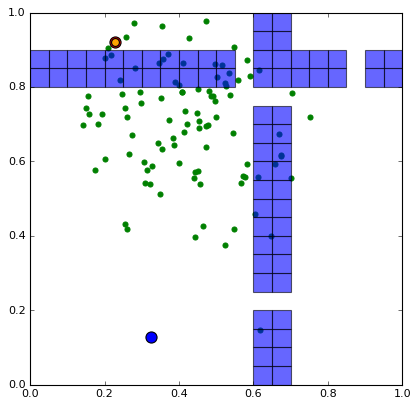

In [127]:
# plot the latent space
num_viz = 100
print("c_test.shape = ",c_test.shape)
# print(c_test[:,:4])
vizIdx = randint(0,numTrain-1);
vizIdx = 2273528
print vizIdx
c_sample_seed = c_train[vizIdx,:]
occ_g = c_train[vizIdx,4:].reshape(20,20)
ts = X_train[vizIdx,:2]
print("Training Sample = ",ts)

# print(c_sample_seed[:4])
init = c_sample_seed[:2]
print("init = ",init)
goal = c_sample_seed[2:4]
print("goal = ",goal)
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)

print("c_sample.shape = ",c_sample.shape)
# directly sample from the latent space (preferred, what we will use in the end)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,1],y_viz[:,0], color="green", s=20)

for i in range(20):
        for j in range(20):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (j/20.0, i/20.0),   # (x,y)
                0.05,          # width
                0.05,          # height
                alpha=0.6
                ))

plt.scatter(init[1], init[0], color="red", s=100, edgecolors='black') # init
plt.scatter(goal[1], goal[0], color="blue", s=100, edgecolors='black') # goal
plt.scatter(ts[1], ts[0], color="orange", s=50, edgecolors='black') # init

plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig("output_"+str(vizIdx)+".jpg", bbox_inches='tight')
plt.show()

